In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from get_network import normalize

In [65]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries

In [4]:
images = np.load('data/images.npy')

In [6]:
norm_im_batch = normalize(images)

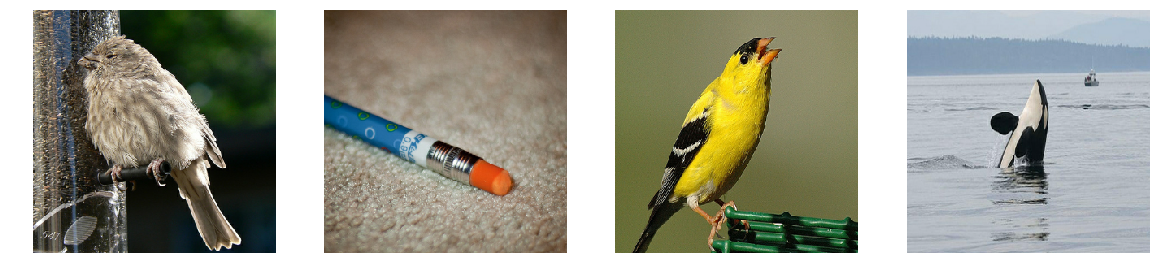

In [8]:
num_images = norm_im_batch.shape[0]
fig, axs = plt.subplots(1, num_images, figsize=(20, 20*num_images))
for i in range(num_images):
    axs[i].imshow(norm_im_batch[i])
    axs[i].axis('off')

In [82]:
slic_masks = []
f_masks = []
for image in norm_im_batch:
    f_masks.append(felzenszwalb(image, scale=400, sigma=0.5, min_size=400))
    slic_masks.append(slic(image, n_segments=60, compactness=40, convert2lab=True))
slic_masks = np.array(slic_masks)
f_masks = np.array(f_masks)

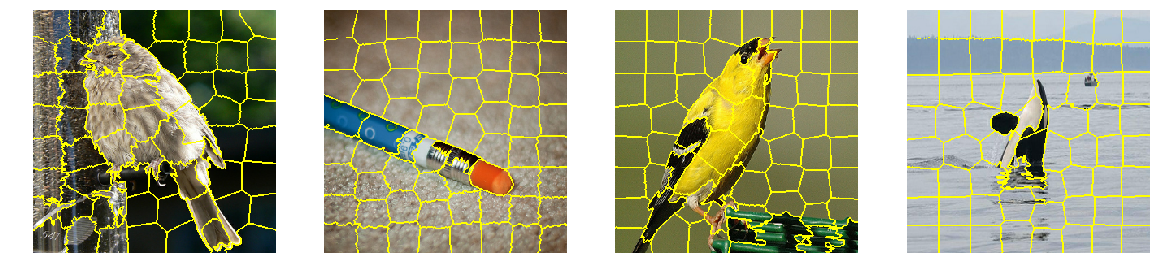

In [83]:
num_images = norm_im_batch.shape[0]
fig, axs = plt.subplots(1, num_images, figsize=(20, 20*num_images))
for i in range(num_images):
    axs[i].imshow(mark_boundaries(norm_im_batch[i], slic_masks[i]))
    axs[i].axis('off')

In [84]:
np.save('data/segmentation.npy', slic_masks)

In [109]:
norm_im_batch[0].max()

1.0

In [111]:
norm_im_batch[i, slic_masks[i] == k, :].shape

(1131, 3)

In [113]:
np.mean(norm_im_batch[i, slic_masks[i] == k, :], axis=0)

array([0.6464538 , 0.66753954, 0.6905514 ], dtype=float32)

In [117]:
image_indices = []
cluster_indices = []
mean_rs = []
mean_gs = []
mean_bs = []
for i in range(num_images):
    for k in np.unique(slic_masks[i]):
        mean_vals = np.mean(norm_im_batch[i, slic_masks[i] == k, :], axis=0) * 255.0
        mean_vals = mean_vals.astype(dtype=np.int64)
        
        image_indices.append(i)
        cluster_indices.append(k)
        mean_rs.append(mean_vals[0])
        mean_gs.append(mean_vals[1])
        mean_bs.append(mean_vals[2])
mean_df = pd.DataFrame({
    'image_index': image_indices,
    'cluster_index': cluster_indices,
    'r': mean_rs,
    'g': mean_gs,
    'b': mean_bs
})

In [118]:
mean_df.shape

(251, 5)

In [119]:
mean_df.head()

,image_index,cluster_index,r,g,b
0,0,0,98,99,100
1,0,1,60,61,59
2,0,2,146,143,136
3,0,3,10,27,8
4,0,4,20,49,4


In [152]:
mean_df.to_csv('data/cluster_means.csv', index=False)

In [141]:
image_color_masks = np.zeros(images.shape, dtype=np.int64)

In [146]:
for i in range(num_images):
    for k in np.unique(slic_masks[i]):
        selected_row = mean_df.loc[np.logical_and(mean_df['image_index'] == i, mean_df['cluster_index'] == k)]
        image_color_masks[i, slic_masks[i] == k, 0] = selected_row.loc[:, 'r'].values[0]
        image_color_masks[i, slic_masks[i] == k, 1] = selected_row.loc[:, 'g'].values[0]
        image_color_masks[i, slic_masks[i] == k, 2] = selected_row.loc[:, 'b'].values[0]

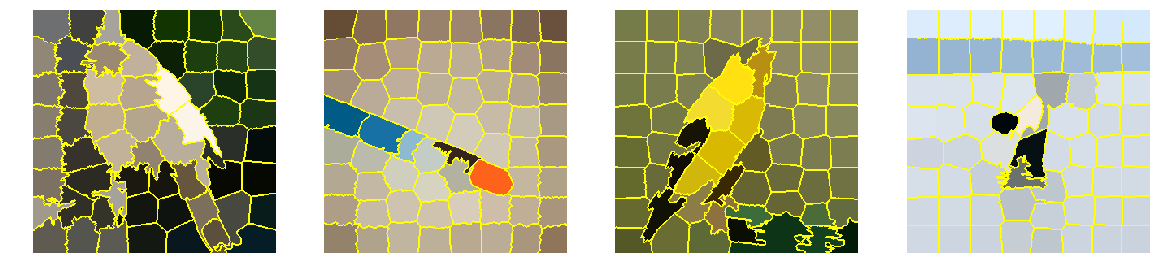

In [175]:
fig, axs = plt.subplots(1, num_images, figsize=(20, 20*num_images))
for i in range(num_images):
    axs[i].imshow(mark_boundaries(normalize(image_color_masks[i]), slic_masks[i]).astype(np.float64), alpha=1.0)
    axs[i].axis('off')